### Recommendations with MovieTweetings: Getting to Know The Data

This notebook is a part of Udacity's Data Science Nanodegree project. I will walk you through the  [MovieTweetings Data](https://github.com/sidooms/MovieTweetings/tree/master/recsyschallenge2014). You can find more information [here](http://crowdrec2013.noahlab.com.hk/papers/crowdrec2013_Dooms.pdf). This data will be used in the recommendation engines in the course.
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

#### 1. Take a look at the data

Take a look at the data - the dataframe `movies` and `reviews`. Since the data was processed from the original data prior to the loading. The following cells will show only the original columns.

In [2]:
movies_ori = movies[['movie_id', 'movie', 'genre', 'date']]
movies_ori.head()

,movie_id,movie,genre,date
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894
1,10,La sortie des usines Lumière (1895),Documentary|Short,1895
2,12,The Arrival of a Train (1896),Documentary|Short,1896
3,25,The Oxford and Cambridge University Boat Race ...,NaN,1895
4,91,Le manoir du diable (1896),Short|Horror,1896


In [3]:
reviews_ori = reviews[['user_id', 'movie_id', 'rating', 'timestamp', 'date']]
reviews_ori.head()

,user_id,movie_id,rating,timestamp,date
0,1,68646,10,1381620027,2013-10-13 01:20:27
1,1,113277,10,1379466669,2013-09-18 03:11:09
2,2,422720,8,1412178746,2014-10-01 17:52:26
3,2,454876,8,1394818630,2014-03-14 18:37:10
4,2,790636,7,1389963947,2014-01-17 14:05:47


#### 2. Data processing

The data is processed here to add more information as follows:

#### Movies
* Pull the date from the title and create new column
* Dummy the date column with 1's and 0's for each century of a movie (1800's, 1900's, and 2000's)
* Dummy column the genre with 1's and 0's for each genre

#### Reviews
* Create a date out of time stamp


In [4]:
# pull date if it exists
create_date = lambda val: val[-5:-1] if val[-1] == ')' else np.nan

# apply the function to pull the date
movies['date'] = movies['movie'].apply(create_date)

# Return century of movie as a dummy column
def add_movie_year(val):
    if val[:2] == yr:
        return 1
    else:
        return 0
        
# Apply function
for yr in ['18', '19', '20']:
    movies[str(yr) + "00's"] = movies['date'].apply(add_movie_year)


In [5]:
# number of different genres
genres = []
for val in movies.genre:
    try:
        genres.extend(val.split('|'))
    except AttributeError:
        pass

# we end up needing this later
genres = set(genres)

# Function to split and return values for columns
def split_genres(val):
    try:
        if val.find(gene) >-1:
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# Apply function for each genre
for gene in genres:        
    movies[gene] = movies['genre'].apply(split_genres)

In [6]:
movies.head() #Check what it looks like

,movie_id,movie,genre,date,1800's,1900's,2000's,History,News,Horror,...,Fantasy,Romance,Game-Show,Action,Documentary,Animation,Comedy,Short,Western,Thriller
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,10,La sortie des usines Lumière (1895),Documentary|Short,1895,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,12,The Arrival of a Train (1896),Documentary|Short,1896,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,25,The Oxford and Cambridge University Boat Race ...,NaN,1895,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,91,Le manoir du diable (1896),Short|Horror,1896,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [7]:
import datetime

change_timestamp = lambda val: datetime.datetime.fromtimestamp(int(val)).strftime('%Y-%m-%d %H:%M:%S')

reviews['date'] = reviews['timestamp'].apply(change_timestamp)

In [8]:
reviews.head()

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-13 01:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 03:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,422720,8,1412178746,2014-10-01 17:52:26,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2,454876,8,1394818630,2014-03-14 18:37:10,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2,790636,7,1389963947,2014-01-17 14:05:47,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### 3. Manupulate data to answer the questions

To answer the first question:

#### How many movies released each year?

One should sort the movie information by their released date according to `date` column first. Then, aggregate the movies by `date` by `count` function. Afterwards, extract these information to the plot. Note that the information before 2013 is kept due to the fact the original paper was published in this year. It is expected that the data was fully maintained up until that point.

In [9]:
# remove movies information after 2013
movies['date'] = movies['date'].astype(int)
movies = movies[movies['date']<=2013]

# sort the movies
movies_sorted = movies.sort_values(by = ['date'])
movies_sorted.head()

,movie_id,movie,genre,date,1800's,1900's,2000's,History,News,Horror,...,Fantasy,Romance,Game-Show,Action,Documentary,Animation,Comedy,Short,Western,Thriller
21925,2221420,Sallie Gardner at a Gallop (1878),Short,1878,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12766,392728,Roundhay Garden Scene (1888),Documentary|Short,1888,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,10,La sortie des usines Lumière (1895),Documentary|Short,1895,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,25,The Oxford and Cambridge University Boat Race ...,NaN,1895,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# aggregate the data and remove the data after 2013
mov_count = pd.DataFrame(movies_sorted.groupby('date').count()['movie_id'])
mov_count.columns = ['movie_count']


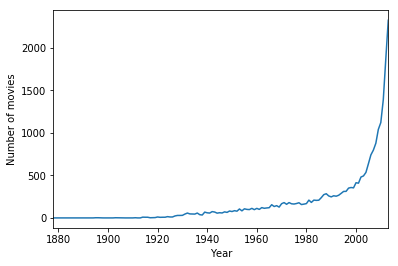

In [11]:
# plot
mov_count.plot(legend=None)
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.show()

#### Do big name movies received big ratings?

Assume that big name movies are rated by big amount of users, will they receive big average rating?

In [12]:
# prepare data for ranking - functions taken from Recommendation Engines part
def create_ranked_df(movies, reviews):
        '''
        INPUT
        movies - the movies dataframe
        reviews - the reviews dataframe
        
        OUTPUT
        ranked_movies - a dataframe with movies that are sorted by highest avg rating, more reviews, 
                        then time, and must have more than 4 ratings
        '''
        
        # Pull the average ratings and number of ratings for each movie
        movie_ratings = reviews.groupby('movie_id')['rating']
        avg_ratings = movie_ratings.mean()
        num_ratings = movie_ratings.count()
        last_rating = pd.DataFrame(reviews.groupby('movie_id').max()['date'])
        last_rating.columns = ['last_rating']

        # Add Dates
        rating_count_df = pd.DataFrame({'avg_rating': avg_ratings, 'num_ratings': num_ratings})
        rating_count_df = rating_count_df.join(last_rating)

        # merge with the movies dataset
        movie_recs = movies.set_index('movie_id').join(rating_count_df)

        # sort by top avg rating and number of ratings
        ranked_movies = movie_recs.sort_values(['avg_rating', 'num_ratings', 'last_rating'], ascending=False)

        # for edge cases - subset the movie list to those with only 5 or more reviews
        ranked_movies = ranked_movies[ranked_movies['num_ratings'] > 4]
        
        return ranked_movies
    

def popular_recommendations(user_id, n_top, ranked_movies):
    '''
    INPUT:
    user_id - the user_id (str) of the individual you are making recommendations for
    n_top - an integer of the number recommendations you want back
    ranked_movies - a pandas dataframe of the already ranked movies based on avg rating, count, and time

    OUTPUT:
    top_movies - a list of the n_top recommended movies by movie title in order best to worst
    '''

    top_movies = list(ranked_movies['movie'][:n_top])

    return top_movies


In [13]:
# create ranking
ranked_movies = create_ranked_df(movies, reviews) # only run this once - it is not fast

In [14]:
# take a quick look
ranked_movies.head(20)

,movie,genre,date,1800's,1900's,2000's,History,News,Horror,Musical,...,Action,Documentary,Animation,Comedy,Short,Western,Thriller,avg_rating,num_ratings,last_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
2737018,Selam (2013),Drama|Romance,2013,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,10.000000,10,2015-05-11 00:56:01
2219210,Crawl Bitch Crawl (2012),Horror|Sci-Fi|Thriller,2012,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,10.000000,6,2013-07-23 01:30:52
2059318,Third Contact (2011),Mystery|Sci-Fi|Thriller,2011,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,10.000000,5,2014-02-13 16:48:31
1431149,Romeo Juliet (2009),Drama,2009,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,10.000000,5,2013-07-26 19:19:01
111341,Sátántangó (1994),Comedy|Drama,1994,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,9.800000,5,2018-03-09 09:09:54
423176,Shijie (2004),Drama,2004,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,9.800000,5,2015-07-05 04:27:46
1629443,Foster (2011),Comedy|Drama|Family,2011,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,9.800000,5,2014-03-16 00:37:57
2592910,CM101MMXI Fundamentals (2013),Documentary|Comedy,2013,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,9.666667,9,2013-09-20 15:43:47
58888,Akahige (1965),Drama,1965,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,9.666667,6,2017-08-18 01:25:54


In [15]:
# sort the movies by num_ratings
ranked_movies_sort_num = ranked_movies.sort_values(by='num_ratings', ascending=True)
ranked_movies_sort_num.head()

,movie,genre,date,1800's,1900's,2000's,History,News,Horror,Musical,...,Action,Documentary,Animation,Comedy,Short,Western,Thriller,avg_rating,num_ratings,last_rating
movie_id,,,,,,,,,,,,,,,,,,,,,
465436,December Boys (2007),Drama|Romance,2007,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,7.2,5,2014-01-21 14:44:59
382992,Stealth (2005),Action|Adventure|Sci-Fi,2005,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,6.8,5,2015-10-29 18:13:14
2445698,Entre Nós (2013),Drama,2013,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,6.8,5,2015-11-07 15:35:23
1068956,Khuda Kay Liye (2007),Crime|Drama|Thriller,2007,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,6.8,5,2016-01-05 03:39:35
1147684,Forget Me Not (2009),Horror|Romance|Thriller,2009,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,6.8,5,2016-02-08 20:40:22


Text(0, 0.5, 'Average rating (out of 10)')

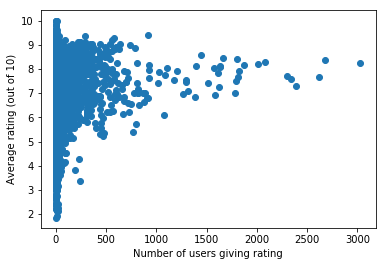

In [16]:
# plot
plt.scatter((ranked_movies_sort_num['num_ratings']), ranked_movies_sort_num['avg_rating'])
plt.xlabel('Number of users giving rating')
plt.ylabel('Average rating (out of 10)')